# Data Augmentation

In [1]:
import cv2 
import random
import numpy as np
import os
import matplotlib.pyplot as plt

In [2]:
def fill(img, h, w):
    img = cv2.resize(img, (h, w), cv2.INTER_CUBIC)
    return img

def horizontal_shift(img, ratio=0.0):
    if ratio > 1 or ratio < 0:
        print('Value should be less than 1 and greater than 0')
        return img
    ratio = random.uniform(-ratio, ratio)
    h, w = img.shape[:2]
    to_shift = w*ratio
    if ratio > 0:
        img = img[:, :int(w-to_shift), :]
    if ratio < 0:
        img = img[:, int(-1*to_shift):, :]
    img = fill(img, h, w)
    return img

def vertical_shift(img, ratio=0.0):
    if ratio > 1 or ratio < 0:
        print('Value should be less than 1 and greater than 0')
        return img
    ratio = random.uniform(-ratio, ratio)
    h, w = img.shape[:2]
    to_shift = h*ratio
    img = img[:int(h-to_shift), :, :]
    img = fill(img, h, w)
    return img


def change_brightness(img, value=30):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv)
    v = cv2.add(v,value)
    v[v > 255] = 255
    v[v < 0] = 0
    final_hsv = cv2.merge((h, s, v))
    img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)
    return img

def zoom(img, value):
    if value > 1 or value < 0:
        print('Value for zoom should be less than 1 and greater than 0')
        return img
    value = random.uniform(value, 1)
    h, w = img.shape[:2]
    h_taken = int(value*h)
    w_taken = int(value*w)
    h_start = random.randint(0, h-h_taken)
    w_start = random.randint(0, w-w_taken)
    img = img[h_start:h_start+h_taken, w_start:w_start+w_taken, :]
    img = fill(img, h, w)
    return img

def horizontal_flip(img):
    return cv2.flip(img, 1)

def vertical_flip(img):
    return cv2.flip(img, 0)
   
    
def rotation(img, angle):
    angle = int(random.uniform(-angle, angle))
    h, w = img.shape[:2]
    M = cv2.getRotationMatrix2D((int(w/2), int(h/2)), angle, 1)
    img = cv2.warpAffine(img, M, (w, h))
    return img

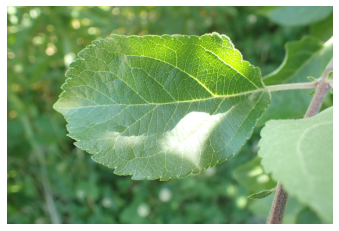

In [3]:
img = cv2.imread('./DL_Data/Train/Healthy/8bd27e8d6124a5b3.jpg')
plt.axis("off")
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

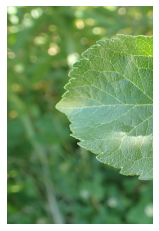

In [4]:
image = horizontal_shift(img,0.6)

plt.axis("off")
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()

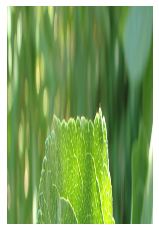

In [5]:

image = vertical_shift(img, 0.9)

plt.axis("off")
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()

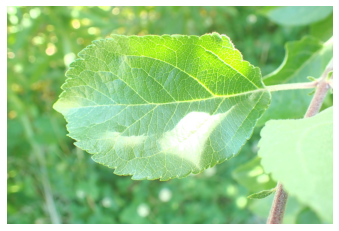

In [6]:
image = change_brightness(img,50)

plt.axis("off")
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()

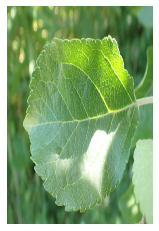

In [7]:
image = zoom(img,0.5)

plt.axis("off")
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()

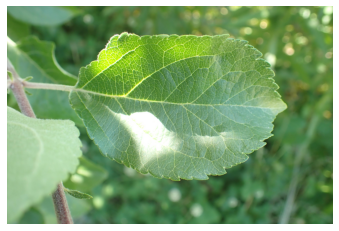

In [8]:

image = horizontal_flip(img)

plt.axis("off")
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()

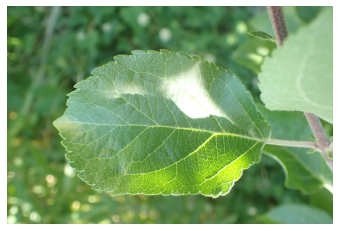

In [9]:
image = vertical_flip(img)

plt.axis("off")
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()

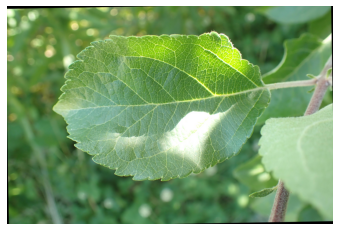

In [10]:
image = rotation(img, 12)

plt.axis("off")
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()

# Model development

In [11]:
# importing libraries 
import keras
from keras.preprocessing.image import ImageDataGenerator 
from keras.models import Sequential, save_model, load_model
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization
from keras.layers import Activation, Dropout, Flatten, Dense 
import numpy as np
from keras.callbacks import TensorBoard
import time
import matplotlib.pyplot as plt
import datetime
import cv2
import os
import tensorflow as tf
import tensorflow.keras
import cv2
from pathlib import Path
print('tf version', tf.__version__)
print('keras version', tf.keras.__version__)
print('gpu is ','available' if tf.config.list_physical_devices('GPU') else 'not available')

tf version 2.8.0
keras version 2.8.0
gpu is  available


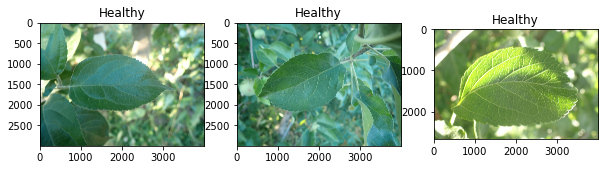

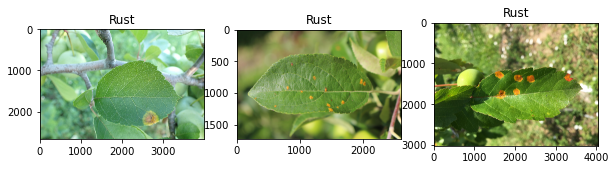

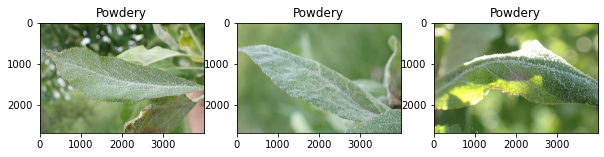

In [12]:
import random

def rescale_and_plot_images(image_files,class_name):
    for idx, img_path in enumerate(image_files):
        plt.subplot(3, 3, idx + 1)
        img = plt.imread(img_path)
        plt.imshow(img, cmap = 'gray')
        plt.title(class_name)

def plot_images(path, class_name):
    image_paths = []
    class_name_path = os.path.join(path, class_name)
    image_paths = [os.path.join(class_name_path, img_png) for img_png in random.sample(os.listdir(class_name_path), 3)]
    
    plt.figure(figsize = (10, 25))
    rescale_and_plot_images(image_paths,class_name)
    

plot_images('./DL_Data/Train/', 'Healthy')
plot_images('./DL_Data/Train/', 'Rust')
plot_images('./DL_Data/Train/', 'Powdery')

## Train dataset

In [13]:
subdir = ['Healthy','Powdery','Rust']



path = './DL_Data/Train/'

target_name = {'Healthy':0,'Powdery':1,'Rust':2}

num_of_class = 9

X_train, y_train = [], []
for disease in subdir:
    for img_name in os.listdir(path+disease):
        img = cv2.imread(path+disease+'/'+img_name)
        scalled_raw_img = cv2.resize(img, (64, 64))/255.0
        X_train.append(scalled_raw_img)
        y_train.append(target_name[disease])

In [14]:
X_train, y_train = np.array(X_train), np.array(y_train)

X_train.shape, y_train.shape

((1322, 64, 64, 3), (1322,))

In [15]:
y_train = tf.keras.utils.to_categorical(y_train, num_classes=num_of_class)
X_train.shape, y_train.shape

((1322, 64, 64, 3), (1322, 9))

## Test dataset

In [16]:
path = './DL_Data/Test/'
X_test, y_test = [], []
for disease in subdir:
    for img_name in os.listdir(path+disease):
        img = cv2.imread(path+disease+'/'+img_name)
        scalled_raw_img = cv2.resize(img, (64, 64))/255.0
        X_test.append(scalled_raw_img)
        y_test.append(target_name[disease])

In [17]:
X_test, y_test = np.array(X_test), np.array(y_test)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=num_of_class)

X_test.shape, y_test.shape

((150, 64, 64, 3), (150, 9))

In [18]:
input_shape = (64, 64, 3) 

model = Sequential()

model.add(Conv2D(32, (3,3), input_shape=input_shape, activation='relu',data_format='channels_last'))
model.add(MaxPooling2D((2,2), strides=(1,1), padding='same'),)

model.add(Conv2D(64, (3,3), activation='relu'),)
model.add(MaxPooling2D((2,2), strides=(1,1), padding='same'),)

model.add(Conv2D(128, (3,3), activation='relu'),)
model.add(MaxPooling2D((2,2), strides=(1,1), padding='same'),)


model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))

model.add(Dropout(0.5))
model.add(Dense(num_of_class, activation='softmax'))

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 62, 62, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 60, 60, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 60, 60, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 58, 58, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 58, 58, 128)      0

In [20]:
model.compile(loss ='categorical_crossentropy',
                     optimizer ='adam', 
                   metrics =['accuracy'])

In [21]:
H = model.fit(
    x=X_train,
    y=y_train,
    batch_size=64,
    epochs=50,
    validation_data=(X_test, y_test)) #Model Training

Epoch 1/50
21/21 [==============================] - 7s 115ms/step - loss: 2.2824 - accuracy: 0.3873 - val_loss: 0.8714 - val_accuracy: 0.7133
Epoch 2/50
21/21 [==============================] - 2s 78ms/step - loss: 0.9326 - accuracy: 0.6233 - val_loss: 0.7361 - val_accuracy: 0.6667
Epoch 3/50
21/21 [==============================] - 2s 78ms/step - loss: 0.6995 - accuracy: 0.7209 - val_loss: 0.6281 - val_accuracy: 0.7600
Epoch 4/50
21/21 [==============================] - 2s 78ms/step - loss: 0.4955 - accuracy: 0.8177 - val_loss: 0.5550 - val_accuracy: 0.7600
Epoch 5/50
21/21 [==============================] - 2s 83ms/step - loss: 0.3925 - accuracy: 0.8638 - val_loss: 0.4444 - val_accuracy: 0.8467
Epoch 6/50
21/21 [==============================] - 2s 85ms/step - loss: 0.3540 - accuracy: 0.8873 - val_loss: 0.5355 - val_accuracy: 0.8467
Epoch 7/50
21/21 [==============================] - 2s 84ms/step - loss: 0.2763 - accuracy: 0.9160 - val_loss: 0.4641 - val_accuracy: 0.8600
Epoch 8/50
2

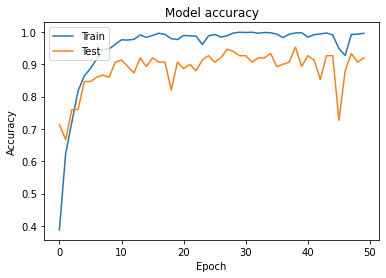

In [22]:
# Plot training & validation accuracy values
fig, ax = plt.subplots(1,1)
plt.plot(H.history["accuracy"])
plt.plot(H.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


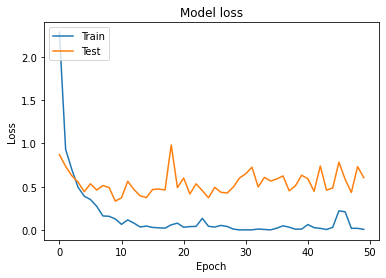

In [23]:
# Plot training & validation loss values
fig, ax = plt.subplots(1,1)
plt.plot(H.history['loss'])
plt.plot(H.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

Classification Report
              precision    recall  f1-score   support

     Healthy       0.85      1.00      0.92        50
     Powdery       0.98      0.86      0.91        50
        Rust       0.96      0.90      0.93        50

    accuracy                           0.92       150
   macro avg       0.93      0.92      0.92       150
weighted avg       0.93      0.92      0.92       150



Text(69.0, 0.5, 'Predicted')

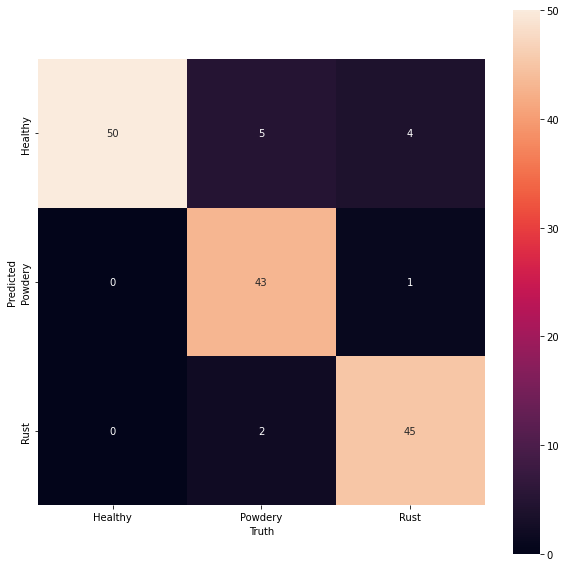

In [27]:
#### X test####

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred = np.argmax(model.predict(X_test,batch_size=1), axis=1) 

print('Classification Report')
y_classes = [np.argmax(y, axis=None, out=None) for y in y_test]
report = classification_report(y_classes, y_pred, target_names=target_name.keys())
print(report)

plt.figure(figsize=(10,10))
cm = confusion_matrix(y_classes, y_pred)
_=sns.heatmap(cm.T, annot=True, fmt='d', cbar=True, square=True, xticklabels=target_name.keys(),
             yticklabels=target_name.keys())


plt.xlabel('Truth')
plt.ylabel('Predicted')